# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results.

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

In [1]:
# First import the necessary libraries
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
TRAIN_DIR = 'horse-or-human/train'
VAL_DIR = 'horse-or-human/validation'

# Directory with training horse pictures
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')

# Directory with training human pictures
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join(VAL_DIR, 'horses')

# Directory with validation human pictures
validation_human_dir = os.path.join(VAL_DIR, 'humans')

In [3]:
def create_model():
  '''Builds a CNN for image binary classification'''

  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(300,300,3)),
      # This will rescale the image to [0,1]
      tf.keras.layers.Rescaling(1./255),
      # This is the first convolution
      tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      # The second convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The third convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The fourth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # The fifth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('horses') and 1 for the other ('humans')
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])

  return model


In [4]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)
LABEL_MODE = 'binary'

# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Instantiate the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


## Data Augmentation

You will use the same layers as in the previous lab. This worked well for the Cats and Dogs dataset to avoid overfitting. See if it has the same effect here.

In [5]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
        # Specify the input shape.
        tf.keras.Input(shape=(300,300,3)),
        # Add the augmentation layers
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
        ])

You will again use the `data_augmentation` model on some images to preview the transformations.

In [6]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

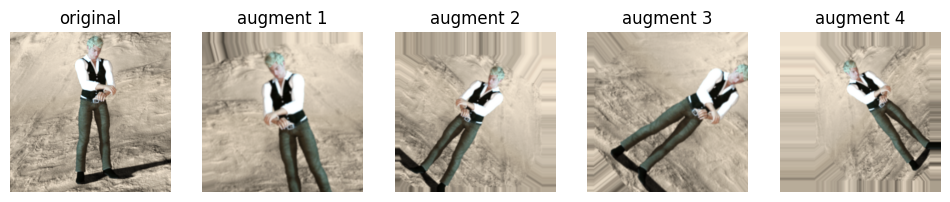

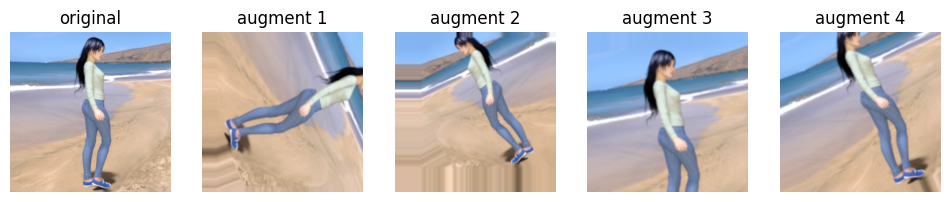

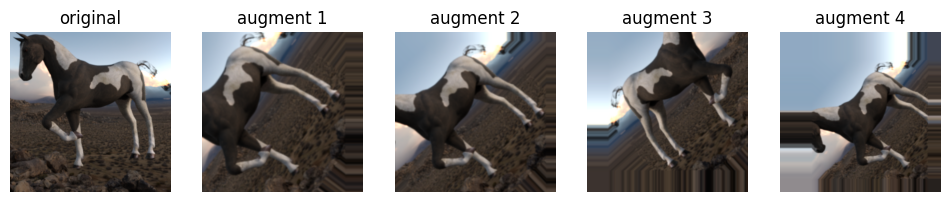

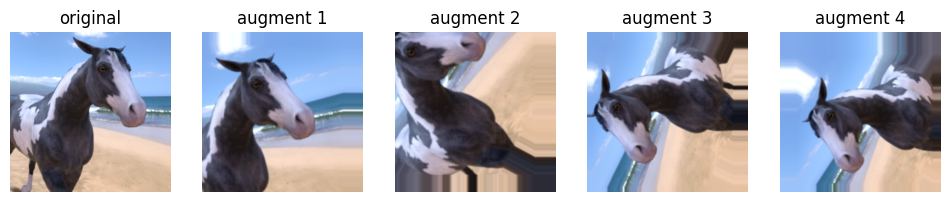

In [7]:
NUM_AUG = 4

# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Delete the variable to free up some memory
del sample_batch

Now create a model attaching the `data_augmentation` model to the base model.

In [8]:
# Instantiate the base model
model_without_aug = create_model()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

# Compile the model
model_with_aug.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

Now train the model for 20 epochs and observe what's happening with the training and validation accuracy. You will plot the results to see it more clearly.

In [9]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=2,
      validation_data = validation_dataset_final)

Epoch 1/20
33/33 - 9s - 264ms/step - accuracy: 0.5696 - loss: 0.6795 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 2/20
33/33 - 1s - 25ms/step - accuracy: 0.6456 - loss: 0.6391 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/20
33/33 - 1s - 25ms/step - accuracy: 0.6777 - loss: 0.6034 - val_accuracy: 0.5000 - val_loss: 0.8297
Epoch 4/20
33/33 - 1s - 25ms/step - accuracy: 0.6894 - loss: 0.5917 - val_accuracy: 0.6289 - val_loss: 0.6426
Epoch 5/20
33/33 - 1s - 25ms/step - accuracy: 0.7030 - loss: 0.5697 - val_accuracy: 0.5000 - val_loss: 0.9969
Epoch 6/20
33/33 - 1s - 25ms/step - accuracy: 0.7205 - loss: 0.5423 - val_accuracy: 0.5000 - val_loss: 0.9522
Epoch 7/20
33/33 - 1s - 25ms/step - accuracy: 0.7420 - loss: 0.5358 - val_accuracy: 0.6016 - val_loss: 0.6257
Epoch 8/20
33/33 - 1s - 25ms/step - accuracy: 0.7322 - loss: 0.5276 - val_accuracy: 0.5000 - val_loss: 1.1114
Epoch 9/20
33/33 - 1s - 25ms/step - accuracy: 0.7702 - loss: 0.5022 - val_accuracy: 0.5000 - val_loss: 1.3768
Epoch 10/

In [10]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

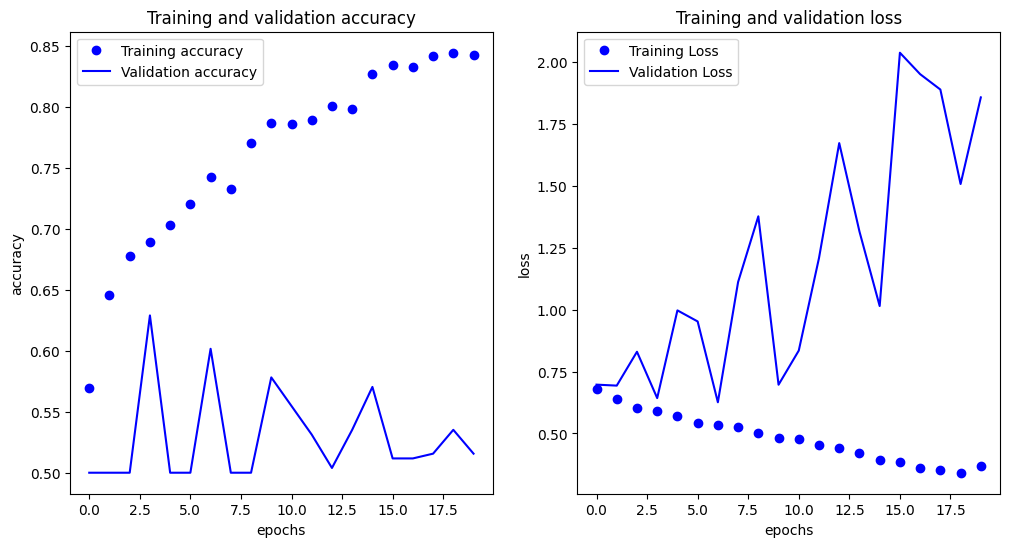

In [11]:
# Plot training results
plot_loss_acc(history)

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the augmented data. It might also be that the background of the training images are also being learned by the model so the white background of the validation set is throwing the prediction off. (_Optional: you can learn about mismatched train/test distributions in [the later parts of this video](https://www.coursera.org/lecture/deep-neural-network/train-dev-test-sets-cxG1s)_).

Use the function below to compare the images on both datasets (note: you can also use the file explorer on the left to explore the images).

In [12]:
def show_images(dir_1, dir_2):
    '''plots 8 images each from two given directories'''

    # Output images in a 2x8 configuration
    nrows = 2
    ncols = 8

    # Get filenames from the two directories
    fnames_dir_1 = os.listdir(dir_1)
    fnames_dir_2 = os.listdir(dir_2)

    # Set up matplotlib fig, and size it to fit 2x8 images
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    # Get 8 random filenames and set the full paths
    next_pix_dir_1 = [os.path.join(dir_1, fname)
                      for fname in random.sample(fnames_dir_1, 8)]
    next_pix_dir_2 = [os.path.join(dir_2, fname)
                      for fname in random.sample(fnames_dir_2, 8)]

    # Plot the chosen images
    for i, img_path in enumerate(next_pix_dir_1 + next_pix_dir_2):

        # Set up subplot. subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)

        # Don't show axes or gridlines
        sp.axis('Off')

        # Load and show the image
        img = tf.keras.utils.load_img(img_path)
        plt.imshow(img)

In [ ]:
# Show random train (first row) and validation (second row) horse images
show_images(train_horse_dir, validation_horse_dir)

In [ ]:
# Show random train (first row) and validation (second row) human images
show_images(train_human_dir, validation_human_dir)

Based on these and the preview of the tranformed images earlier, see if it's possible to modify the data augmentation model to avoid overfitting. Getting satisfactory results can be difficult, and at this point, you can consider other techniques. You will see that in next week's lessons.